# Unsupervised Learning

In [5]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

**Connect Google Drive to Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls /content/gdrive/MyDrive

## K-Means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# data from https://datatofish.com/k-means-clustering-python/
X = np.array([
    [25,34,22,27,33,33,31,22,35,34,67,54,57,43,50,57,59,52,65,47,49,48,35,33,44,45,38,43,51,46],
    [79,51,53,78,59,74,73,57,69,75,51,32,40,47,53,36,35,58,59,50,25,20,14,12,20,5,29,27,8,7]
])
plt.scatter(X[0], X[1])

In [ ]:
kmeans = KMeans(n_clusters=4, init='random')
kmeans.fit(X.transpose())

In [ ]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

In [ ]:
plt.figure()
plt.scatter(X[0], X[1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red')

In [ ]:
# test with new points
kmeans.predict(np.array([[30,70]]))

### Evaluating KMeans

In [ ]:
kmeans.inertia_

In [ ]:
# the elbow!
elbow = []
n_clusters = range(1,15)
for K in n_clusters:
    kmeans = KMeans(n_clusters=K, init='random')
    kmeans.fit(X.transpose())
    elbow.append(kmeans.inertia_)
plt.plot(n_clusters, elbow)

## Autoencoders

In [8]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

train_dataset = MNIST('.data', download=True, train=True, transform=ToTensor())
test_dataset = MNIST('.data', download=True, train=False, transform=ToTensor()) # we will never use it! Why?

# filter out some labels
idx = (train_dataset.targets==0) | (train_dataset.targets==1)  | (train_dataset.targets==2) 
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

tr_length = int(len(train_dataset) * 0.7)
print(tr_length)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                [tr_length, len(train_dataset)-tr_length])

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

13036


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [10]:
# what about using MLP to implement Autoencoder?
class Autoencoder(nn.Module):
    def __init__(self, hidden_size):

        super(Autoencoder, self).__init__()
        
        input_size = 28*28
        self.enc1 = nn.Linear(input_size, 400)
        self.enc2 = nn.Linear(400, 100)
        self.enc3 = nn.Linear(100, 50)
        self.enc = nn.Linear(50, hidden_size)
        self.dec1 = nn.Linear(hidden_size, 50)
        self.dec2 = nn.Linear(50, 100)
        self.dec3 = nn.Linear(100, 400)
        self.dec4 = nn.Linear(400, input_size)

    def forward(self, x):
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        x = torch.relu(self.enc3(x))
        self.code = self.enc(x)
        x = torch.relu(self.code)
        x = torch.relu(self.dec1(x))
        x = torch.relu(self.dec2(x))
        x = torch.relu(self.dec3(x))
        out = torch.relu(self.dec4(x))
        return out

In [11]:
autoencoder = Autoencoder(2).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
                             #weight_decay=1e-2)
criterion = torch.nn.MSELoss()

In [12]:
EPOCHS = 50

tr_loss = []
val_loss = []
for epoch in range(EPOCHS):
    trl = 0.
    for x,_ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        optimizer.zero_grad()    
        out = autoencoder(x)
        loss = criterion(out, x)
        loss.backward()
        optimizer.step()
        trl += loss.item()
        
    tr_loss.append(trl / float(len(train_loader)))    
    
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.view(x.size(0), -1).to(device)
            out = autoencoder(x)
            vll = criterion(out, x)
            val_loss.append(vll.item())
            
    print(f'End epoch {epoch}')

End epoch 0
End epoch 1
End epoch 2
End epoch 3
End epoch 4
End epoch 5
End epoch 6
End epoch 7
End epoch 8
End epoch 9
End epoch 10
End epoch 11
End epoch 12
End epoch 13
End epoch 14
End epoch 15
End epoch 16
End epoch 17
End epoch 18
End epoch 19
End epoch 20
End epoch 21
End epoch 22
End epoch 23
End epoch 24
End epoch 25
End epoch 26
End epoch 27
End epoch 28
End epoch 29
End epoch 30
End epoch 31
End epoch 32
End epoch 33
End epoch 34
End epoch 35
End epoch 36
End epoch 37
End epoch 38
End epoch 39
End epoch 40
End epoch 41
End epoch 42
End epoch 43
End epoch 44
End epoch 45
End epoch 46
End epoch 47
End epoch 48
End epoch 49


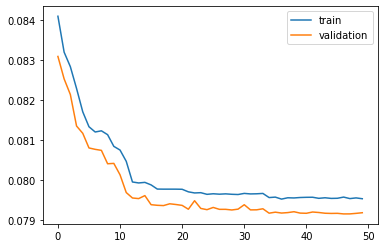

In [13]:
plt.plot(range(len(tr_loss)), tr_loss, label='train')
plt.plot(range(len(val_loss)), val_loss, label='validation')
plt.legend(loc='best')

In [14]:
with torch.no_grad():
    for i, (x, y) in enumerate(val_loader):
        x = x.view(x.size(0), -1).to(device)    
        autoencoder(x)
        activations = autoencoder.code.cpu().numpy()
        targets = y.cpu().numpy() 

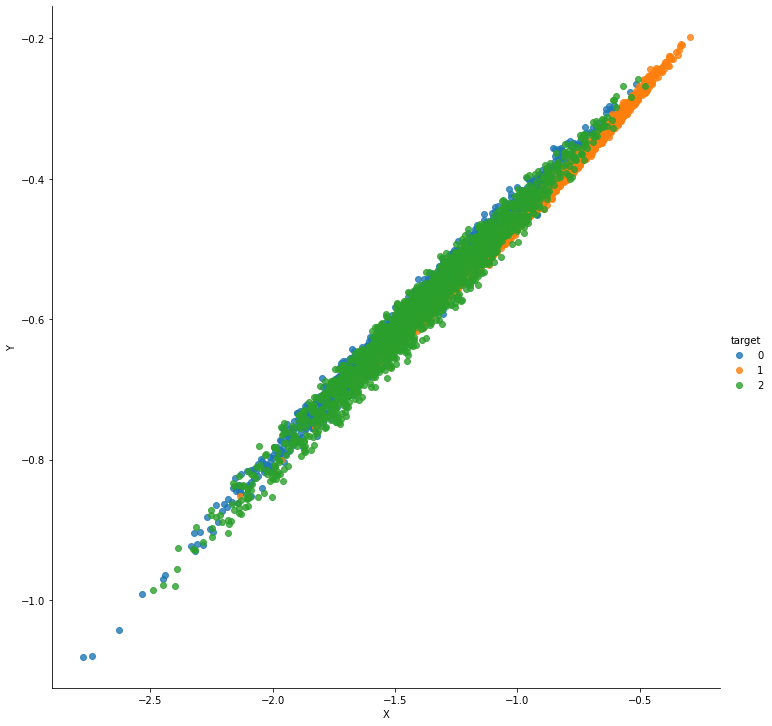

In [15]:
import seaborn as sns
from pandas import DataFrame

points = DataFrame(activations, columns=['X', 'Y'])
points['target'] = targets
sns.lmplot(x='X', y='Y', data=points, hue='target', fit_reg=False, height=10)